Need to upload:
* train.zip
* test.zip_file_path

or

* trainX.pkl
* trainy.pkl
* testX.pkl
* testy.pkl


In [1]:
!pip install keras_facenet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.9 MB/s eta 0:00:00
  Created wheel for keras_facenet: filename=keras_facenet-0.3.2-py3-none-any.whl size=10368 sha256=bba229e7a384117053220afc91e2fcfb207b07149a46f5ec62b032fa186bc06f
  Stored in directory: /root/.cache/pip/wheels/1d/d8/a9/85cf04ea29321d2afcb82c0caaafdca9195385f9d68cbc7185
Successfully built keras_facenet


In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
import numpy as np
import zipfile
import os
import pickle
from tensorflow.keras.models import load_model



Unpacking train and test data

In [ ]:

zip_file_path = '/content/test.zip'

extract_folder_path = '/content/test'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

zip_file_path1 = '/content/train.zip'

extract_folder_path1 = '/content/train'

with zipfile.ZipFile(zip_file_path1, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path1)



Getting face embeddings using FaceNet


In [ ]:
embedder = FaceNet()

def get_embeddings(face_img_path):
    face_img = cv2.imread(face_img_path)
    face_img = face_img.astype('float32')
    face_img = np.expand_dims(face_img, axis=0)
    yhat = embedder.embeddings(face_img)
    return yhat[0]

In [ ]:
main_folder_path = '/content/train'

subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]
new_trainX = list()
new_trainy = list()

for subfolder in subfolders:
    print(f"Processing images in folder: {subfolder}")
    images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.png', '.jpeg'))]
    for image in images:
      new_trainX.append(get_embeddings(image))
      new_trainy.append(subfolder.split('/')[-1])




In [ ]:
main_folder_path = '/content/test'

subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]
new_testX = list()
new_testy = list()

for subfolder in subfolders:
    print(f"Processing images in folder: {subfolder}")
    images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.png', '.jpeg'))]
    for image in images:
      new_testX.append(get_embeddings(image))
      new_testy.append(subfolder.split('/')[-1])




In [ ]:
with open('trainX.pkl', 'wb') as file:
    pickle.dump(new_trainX, file)
with open('trainy.pkl', 'wb') as file:
    pickle.dump(new_trainy, file)
with open('testX.pkl', 'wb') as file:
    pickle.dump(new_testX, file)
with open('testy.pkl', 'wb') as file:
    pickle.dump(new_testy, file)

In [9]:
# with open('trainX.pkl', 'rb') as file:
#     new_trainX =  pickle.load(file)
# with open('trainy.pkl', 'rb') as file:
#     new_trainy =  pickle.load(file)
# with open('testX.pkl', 'rb') as file:
#     new_testX =  pickle.load(file)
# with open('testy.pkl', 'rb') as file:
#     new_testy =  pickle.load(file)

Model training and evaluation


In [10]:
valid_labels = ['Emilka', 'Julka', 'Kacper', 'Kaja', 'Karolina', 'Kuba', 'Maciek', 'Madzia', 'Ola', 'Sylwia', 'Szczepan']
filtered_train_indices = [i for i, label in enumerate(new_trainy) if label in valid_labels]
filtered_test_indices = [i for i, label in enumerate(new_testy) if label in valid_labels]

filtered_trainX = np.asarray(new_trainX)[filtered_train_indices]
filtered_testX = np.asarray(new_testX)[filtered_test_indices]

filtered_trainy = np.asarray(new_trainy)[filtered_train_indices]
filtered_testy = np.asarray(new_testy)[filtered_test_indices]

label_encoder = LabelEncoder()
label_encoder.fit(valid_labels)

filtered_trainy_encoded = label_encoder.transform(filtered_trainy)
filtered_testy_encoded = label_encoder.transform(filtered_testy)

num_classes = len(valid_labels)
filtered_trainy_one_hot = to_categorical(filtered_trainy_encoded, num_classes)
filtered_testy_one_hot = to_categorical(filtered_testy_encoded, num_classes)

trainX, valX, trainy, valy = train_test_split(filtered_trainX, filtered_trainy_one_hot, test_size=0.2, random_state=42)

In [ ]:
model = Sequential()
model.add(Dense(256, input_shape=(512,), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 20
batch_size = 32

history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_data=(valX, valy))


model.save("recognize_people5.h5")
# files.download("recognize_people5.h5")


In [17]:
model.summary()


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_156 (Dense)           (None, 256)               131328    
                                                                 
 dense_157 (Dense)           (None, 128)               32896     
                                                                 
 dense_158 (Dense)           (None, 64)                8256      
                                                                 
 dense_159 (Dense)           (None, 32)                2080      
                                                                 
 dense_160 (Dense)           (None, 11)                363       
                                                                 
Total params: 174923 (683.29 KB)
Trainable params: 174923 (683.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
test_loss, test_accuracy = model.evaluate(filtered_testX, filtered_testy_one_hot)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

52/52 [==============================] - 1s 4ms/step - loss: 0.0530 - accuracy: 0.9892
Test Loss: 0.05300178378820419, Test Accuracy: 0.989182710647583


52/52 [==============================] - 0s 2ms/step


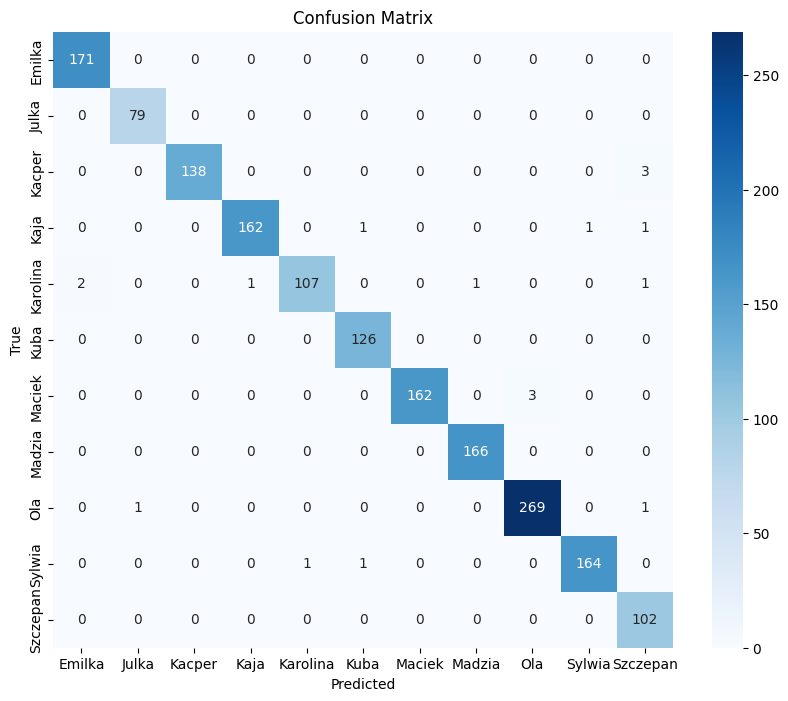

In [13]:

y_pred = np.argmax(model.predict(filtered_testX), axis=1)
y_true = np.argmax(filtered_testy_one_hot, axis=1)


conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=valid_labels, yticklabels=valid_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
class_report = classification_report(y_true, y_pred, target_names=valid_labels)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

      Emilka       0.99      1.00      0.99       171
       Julka       0.99      1.00      0.99        79
      Kacper       1.00      0.98      0.99       141
        Kaja       0.99      0.98      0.99       165
    Karolina       0.99      0.96      0.97       112
        Kuba       0.98      1.00      0.99       126
      Maciek       1.00      0.98      0.99       165
      Madzia       0.99      1.00      1.00       166
         Ola       0.99      0.99      0.99       271
      Sylwia       0.99      0.99      0.99       166
    Szczepan       0.94      1.00      0.97       102

    accuracy                           0.99      1664
   macro avg       0.99      0.99      0.99      1664
weighted avg       0.99      0.99      0.99      1664

